In [107]:
%matplotlib inline

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

X_train = pd.read_csv('./data/nba/X_train.csv')
y_train = pd.read_csv('./data/nba/y_train.csv')

X_test = pd.read_csv('./data/nba/X_test.csv')
print(X_train.shape)
print(X_train.columns)
print(y_train.columns)

X_columns = X_train.columns.values

print(X_train[:4])
print(y_train[:4])

def pd2np(df):
  return df.as_matrix()

X_train = pd2np(X_train)
y_train = pd2np(y_train)

X_test = pd2np(X_test)
print(X_train.shape)

def getACC(ty, py):
    py = py>0.5
    return np.average(ty==py)


from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(criterion='entropy',
                                n_estimators=200, 
                                random_state=1,
                                n_jobs=2)
forest.fit(X_train, y_train)

import matplotlib.pyplot as plt

importances = forest.feature_importances_
# get sort indices in descending order
indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            X_columns[indices[f]], 
                            importances[indices[f]]))

from sklearn.feature_selection import SelectFromModel

sfm = SelectFromModel(forest, threshold=0.175, prefit=True)
X_train_sel = sfm.transform(X_train)

X_train_forest, X_valid_forest, y_train_forest, y_valid_forest = train_test_split(
    X_train_sel, y_train, test_size=0.3, random_state=0)

forest = RandomForestClassifier(criterion='entropy',
                                n_estimators=200, 
                                random_state=1,
                                n_jobs=2)
forest.fit(X_train_forest, y_train_forest)

y_pred = forest.predict(X_valid_forest)
from sklearn.metrics import accuracy_score

print('ACC: %.2f' % getACC(y_valid, y_pred))



(52399, 8)
Index(['PERIOD', 'GAME_CLOCK', 'SHOT_CLOCK', 'DRIBBLES', 'TOUCH_TIME',
       'SHOT_DIST', 'PTS_TYPE', 'CLOSE_DEF_DIST'],
      dtype='object')
Index(['FGM'], dtype='object')
   PERIOD  GAME_CLOCK  SHOT_CLOCK  DRIBBLES  TOUCH_TIME  SHOT_DIST  PTS_TYPE  \
0       2         557        15.5         0         0.7        2.1         2   
1       2         151        20.1         0         0.8        2.7         2   
2       3         448        14.2         0         0.8        5.1         2   
3       1         279        10.6         0         0.6        1.9         2   

   CLOSE_DEF_DIST  
0             0.0  
1             3.4  
2             0.1  
3             2.7  
   FGM
0    1
1    1
2    0
3    1
(52399, 8)


c:\users\ren\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:26: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
c:\users\ren\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:45: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


 1) GAME_CLOCK                     0.203219
 2) SHOT_DIST                      0.199475
 3) SHOT_CLOCK                     0.179909
 4) CLOSE_DEF_DIST                 0.170689
 5) TOUCH_TIME                     0.140588
 6) PERIOD                         0.051054
 7) DRIBBLES                       0.047976
 8) PTS_TYPE                       0.007091


c:\users\ren\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:70: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


ACC: 0.51


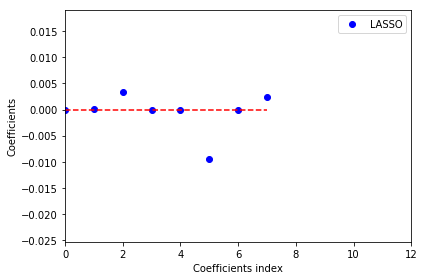

Selected attributes: ['SHOT_CLOCK' 'SHOT_DIST' 'CLOSE_DEF_DIST']


In [108]:
#feature selection using LASSO
var_num = X_train.shape[1]

lr_lasso = Lasso(alpha = 0.1)
lr_lasso.fit(X_train, y_train)

plt.scatter(range(var_num),lr_lasso.coef_, label = 'LASSO', color = 'blue')
plt.hlines(y=0, xmin=0, xmax=var_num-1, color='red', linestyle ='--')
plt.xlim(0,12)
plt.legend(loc = 'upper right')
plt.xlabel('Coefficients index')
plt.ylabel('Coefficients')
plt.tight_layout()
plt.show()

epsilon = 1e-4
idxs = np.where(abs(lr_lasso.coef_) > epsilon)
print('Selected attributes: {}'.format(X_columns[idxs]))

X_train = X_train[:, idxs[0]]
X_test = X_test[:, idxs[0]]

X_train_raw = X_train
y_train_raw = y_train

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.3, random_state=0)

sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_valid_std = sc.transform(X_valid)

In [109]:
poly = PolynomialFeatures(degree=3)
X_poly_train = poly.fit_transform(X_train_std)
X_poly_valid = poly.transform(X_valid_std)

print(X_poly_train.shape)

lr = LinearRegression()
lr.fit(X_train_std, y_train)

print('Linear Regression:')
print('ACC train: %.4f' % getACC(y_train, lr.predict(X_train_std)))
print('ACC valid: %.4f' % getACC(y_valid, lr.predict(X_valid_std)))
print('MSE train: %.4f' % mean_squared_error(y_train, lr.predict(X_train_std)))
print('MSE valid: %.4f' % mean_squared_error(y_valid, lr.predict(X_valid_std)))

lr = LinearRegression()
lr.fit(X_poly_train, y_train)
print('Polynomial Regression:')
print('ACC train: %.4f' % getACC(y_train, lr.predict(X_poly_train)))
print('ACC valid: %.4f' % getACC(y_valid, lr.predict(X_poly_valid)))
print('MSE train: %.4f' % mean_squared_error(y_train, lr.predict(X_poly_train)))
print('MSE valid: %.4f' % mean_squared_error(y_valid, lr.predict(X_poly_valid)))

(36679, 20)
Linear Regression:
ACC train: 0.6034
ACC valid: 0.6109
MSE train: 0.2352
MSE valid: 0.2337
Polynomial Regression:
ACC train: 0.6147
ACC valid: 0.6204
MSE train: 0.2314
MSE valid: 0.2304


In [110]:
from sklearn.linear_model import Ridge

print('Linear:')
for a in [0, 1, 10, 100, 1000]:
    lr_rg = Ridge(alpha=a)
    lr_rg.fit(X_train_std, y_train)

    print('\n[Alpha = %d]' % a )
    print('ACC train: %.4f, valid: %.4f' % (
                    getACC(y_train, lr_rg.predict(X_train_std)),
                    getACC(y_valid, lr_rg.predict(X_valid_std))))  
    
    print('MSE train: %.4f, valid: %.4f' % (
                    mean_squared_error(y_train, lr_rg.predict(X_train_std)),
                    mean_squared_error(y_valid, lr_rg.predict(X_valid_std))))  

    
print('\nPolynomial:')
for a in [0, 1, 10, 100, 1000]:
    lr_rg = Ridge(alpha=a)
    lr_rg.fit(X_poly_train, y_train)

    print('\n[Alpha = %d]' % a )
    print('ACC train: %.4f, valid: %.4f' % (
                    getACC(y_train, lr_rg.predict(X_poly_train)),
                    getACC(y_valid, lr_rg.predict(X_poly_valid)))) 
    
    print('MSE train: %.4f, valid: %.4f' % (
                    mean_squared_error(y_train, lr_rg.predict(X_poly_train)),
                    mean_squared_error(y_valid, lr_rg.predict(X_poly_valid))))  

Linear:

[Alpha = 0]
ACC train: 0.6034, valid: 0.6109
MSE train: 0.2352, valid: 0.2337

[Alpha = 1]
ACC train: 0.6034, valid: 0.6109
MSE train: 0.2352, valid: 0.2337

[Alpha = 10]
ACC train: 0.6033, valid: 0.6109
MSE train: 0.2352, valid: 0.2337

[Alpha = 100]
ACC train: 0.6036, valid: 0.6109
MSE train: 0.2352, valid: 0.2337

[Alpha = 1000]
ACC train: 0.6043, valid: 0.6111
MSE train: 0.2352, valid: 0.2338

Polynomial:

[Alpha = 0]
ACC train: 0.6147, valid: 0.6204
MSE train: 0.2314, valid: 0.2304

[Alpha = 1]
ACC train: 0.6147, valid: 0.6204
MSE train: 0.2314, valid: 0.2304

[Alpha = 10]
ACC train: 0.6147, valid: 0.6204
MSE train: 0.2314, valid: 0.2304

[Alpha = 100]
ACC train: 0.6148, valid: 0.6203
MSE train: 0.2314, valid: 0.2304

[Alpha = 1000]
ACC train: 0.6149, valid: 0.6209
MSE train: 0.2315, valid: 0.2305


In [111]:
from sklearn.linear_model import Lasso

for a in [0.001, 0.01, 0.1, 1, 10]:
    lr_rg = Lasso(alpha=a)
    lr_rg.fit(X_train_std, y_train)

    print('\n[Alpha = %.3f]' % a )
    print('ACC train: %.4f, valid: %.4f' % (
                    getACC(y_train, lr_rg.predict(X_train_std)),
                    getACC(y_valid, lr_rg.predict(X_valid_std))))  
    
    print('MSE train: %.4f, valid: %.4f' % (
                    mean_squared_error(y_train, lr_rg.predict(X_train_std)),
                    mean_squared_error(y_valid, lr_rg.predict(X_valid_std))))  
    
print('\n\n')
for a in [0.001, 0.01, 0.1, 1, 10]:
    lr_rg = Lasso(alpha=a)
    lr_rg.fit(X_poly_train, y_train)

    print('\n[Alpha = %.3f]' % a )
    print('ACC train: %.4f, valid: %.4f' % (
                    getACC(y_train, lr_rg.predict(X_poly_train)),
                    getACC(y_valid, lr_rg.predict(X_poly_valid))))  
    
    print('MSE train: %.4f, valid: %.4f' % (
                    mean_squared_error(y_train, lr_rg.predict(X_poly_train)),
                    mean_squared_error(y_valid, lr_rg.predict(X_poly_valid))))  


[Alpha = 0.001]
ACC train: 0.5109, valid: 0.5104
MSE train: 0.2352, valid: 0.2338

[Alpha = 0.010]
ACC train: 0.5120, valid: 0.5115
MSE train: 0.2357, valid: 0.2346

[Alpha = 0.100]
ACC train: 0.5443, valid: 0.5423
MSE train: 0.2480, valid: 0.2482

[Alpha = 1.000]
ACC train: 0.5443, valid: 0.5423
MSE train: 0.2480, valid: 0.2482

[Alpha = 10.000]
ACC train: 0.5443, valid: 0.5423
MSE train: 0.2480, valid: 0.2482




[Alpha = 0.001]
ACC train: 0.5194, valid: 0.5184
MSE train: 0.2315, valid: 0.2304

[Alpha = 0.010]
ACC train: 0.5187, valid: 0.5179
MSE train: 0.2334, valid: 0.2326

[Alpha = 0.100]
ACC train: 0.5382, valid: 0.5366
MSE train: 0.2427, valid: 0.2426

[Alpha = 1.000]
ACC train: 0.5443, valid: 0.5423
MSE train: 0.2480, valid: 0.2482

[Alpha = 10.000]
ACC train: 0.5443, valid: 0.5423
MSE train: 0.2480, valid: 0.2482


In [112]:
X_train = X_train_raw
y_train = y_train_raw

sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

poly = PolynomialFeatures(degree=3)
X_poly_train = poly.fit_transform(X_train_std)
X_poly_test = poly.transform(X_test_std)

best_rg = Ridge(alpha=1)
best_rg.fit(X_poly_train, y_train)

print('MSE train : %.2f' % mean_squared_error(y_train, best_rg.predict(X_poly_train)))
print('ACC train : %.2f' % getACC(y_train, best_rg.predict(X_poly_train)))

import numpy

y_pred = best_rg.predict(X_poly_test)

y_pred = y_pred>0.5

numpy.savetxt("./output/y_pred.csv", y_pred ,fmt="%d")

MSE train : 0.23
ACC train : 0.62


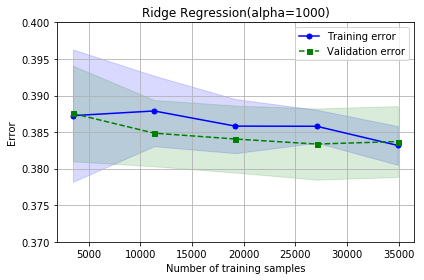

In [113]:
from sklearn.metrics import accuracy_score

def error_measure(model, X, y):
    pred = model.predict(X) > 0.5
    return np.average(y!=pred)

from sklearn.learning_curve import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    estimator=Ridge(alpha=1), X=X_poly_train, y=y_train, scoring=error_measure)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
    color='blue', marker='o',
    markersize=5,
    label='Training error')
plt.fill_between(train_sizes,
    train_mean+train_std,
    train_mean-train_std,
    alpha=0.15, color='blue')
    
plt.plot(train_sizes, test_mean,
    color='green', linestyle='--',
    marker='s', markersize=5,
    label='Validation error')
plt.fill_between(train_sizes,
    test_mean+test_std,
    test_mean-test_std,
    alpha=0.15, color='green')
    
plt.title('Ridge Regression(alpha=1000)')
plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Error')
plt.legend(loc='upper right')
plt.ylim([0.37, 0.4])
plt.tight_layout()
plt.show()

In [114]:
#report
'''
首先，先看到FGM發現值只有0和1，判斷為分類問題，所以先使用之前教過的Random Forest和SelectFromModel挑出3個feature，
然後再使用一次Random Forest得到validation accuracy，值約為0.51，和隨機猜差不多。

為了改進performance，試試看使用regression做binary classification。

首先，先使用LASSO挑出3個feature，分別是'SHOT_CLOCK' 'SHOT_DIST' 'CLOSE_DEF_DIST'，
接著嘗試各種不同model並比較其performance，
衡量performance的方式是將model predict得到的值當中>0.5的視為1，<=0.5視為0，並與ground truth做比較。
過程中嘗試了linear以及polynomial regression，也試過加上penalty term(LASSO和Ridge Regression)的作法，
最後得到最好的model是使用3次方的polynomial feature以及Ridge Regression(alpha=1)，
其validation error為0.2304。

'''

"\n首先，先看到FGM發現值只有0和1，判斷為分類問題，所以先使用之前教過的Random Forest和SelectFromModel挑出3個feature，\n然後再使用一次Random Forest得到validation accuracy，值約為0.51，和隨機猜差不多。\n\n為了改進performance，試試看使用regression做binary classification。\n\n首先，先使用LASSO挑出3個feature，分別是'SHOT_CLOCK' 'SHOT_DIST' 'CLOSE_DEF_DIST'，\n接著嘗試各種不同model並比較其performance，\n衡量performance的方式是將model predict得到的值當中>0.5的視為1，<=0.5視為0，並與ground truth做比較。\n過程中嘗試了linear以及polynomial regression，也試過加上penalty term(LASSO和Ridge Regression)的作法，\n最後得到最好的model是使用3次方的polynomial feature以及Ridge Regression(alpha=1)，\n其validation error為0.2304。\n\n"